# Exploring the datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import numpy as np

## Fix data and unify

In [2]:
dataset_folder = ['.\\datasets\\kaggle DDoS Dataset\\ddos_balanced']
mem_limit = 1_000_000

In [3]:
def serch_csvs_in_folder(paths: list):
    csv_files = []
    for p in paths:
        for dirname, _, filenames in os.walk(p):
            for filename in filenames:
                csv_file = os.path.join(dirname, filename)
                csv_files.append(csv_file)
    
    return csv_files

In [4]:
csv_files=serch_csvs_in_folder(dataset_folder)
print('Found', len(csv_files), 'files!')
csv_files

Found 1 files!


['.\\datasets\\kaggle DDoS Dataset\\ddos_balanced\\final_dataset.csv']

In [5]:
sizes = [str(os.path.getsize(file)/(2.0**30)) + " GB" for file in csv_files]
print(sizes)

['6.328099204227328 GB']


In [19]:
def fix_data(chunk):
    c = chunk.copy() #duplicate chunk to edit it

    c.columns = c.columns.str.strip() #strip spaces from col names

    #drop na and +-inf values
    c.replace([np.inf, -np.inf], np.nan, inplace=True)
    c.dropna(inplace=True)

    #c = c[c['Label'] != 'WebDDoS'] #drop webddos class
    #c = c[c['Label'] != 'Portmap'] #drop portmap class

    #drop useless cols
    c.drop(['Unnamed: 0','Timestamp','Src IP',
            'Flow ID','Dst IP'], axis=1, inplace=True)

    #beautify labels (cut and rename some stuff)
    #c['Label']=c['Label'].str.replace('DrDoS_', '')
    #c['Label']=c['Label'].str.replace('UDP-lag', 'UDPLag')

    return c

In [22]:
only_header = pd.read_csv(csv_files[0], nrows=0)
only_header.columns=only_header.columns.str.strip()
only_header.drop(['Unnamed: 0','Timestamp','Src IP',
            'Flow ID','Dst IP'], axis=1, inplace=True)
only_header.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\unified_jumbo.csv', mode='w', index=False, header=True) #copy only header to final jumbo csv

for ds in csv_files: #for every dataset file
    with pd.read_csv(ds, chunksize=mem_limit) as reader: #that has to be processed in chunks
        for chunk in reader: #for every chunk
            c = fix_data(chunk) #tidy up the dataset
            c.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\unified_jumbo.csv', mode='a', index=False, header=False)


___

## Fair balance

In [6]:
def get_class_distrib(datasets):
    classes_distr = {}
    for ds in datasets:
        with pd.read_csv(ds, chunksize=mem_limit) as reader: #that has to be processed in chunks
            for c in reader:
                labels_count = c['Label'].value_counts()

                for class_, count in labels_count.items():
                    if class_ in classes_distr.keys():
                        classes_distr[class_] += count
                    else:
                        classes_distr[class_] = count

    return classes_distr

In [24]:
classes_distr_precut2 = get_class_distrib(['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\unified_jumbo.csv'])
print(classes_distr_precut2)
%store classes_distr_precut2

{'ddos': 6472617, 'Benign': 6274230}
Stored 'classes_distr_precut2' (dict)


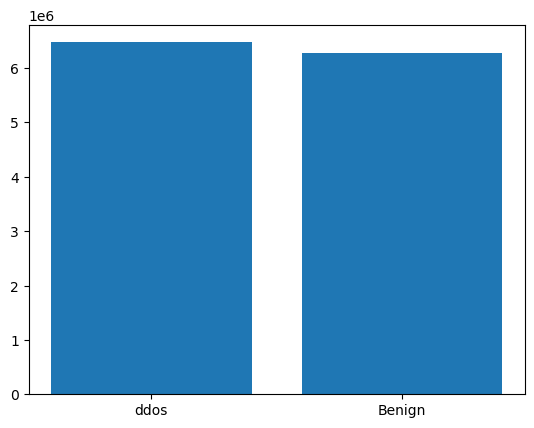

In [7]:
%store -r classes_distr_precut2
plt.bar(classes_distr_precut2.keys(), classes_distr_precut2.values())
plt.show()

In [26]:
min_val = min(classes_distr_precut2.values())
smallest_class = [k for k, v in classes_distr_precut2.items() if v == min_val][0]
print('The class that has less items is', smallest_class, 'with', min_val, 'items.')

The class that has less items is Benign with 6274230 items.


In [27]:
def init_one_class_dataset_storage(where, class_, cols):
    class_dir = os.path.join(where, class_)
    os.mkdir(class_dir)

    only_header=pd.DataFrame(columns=cols)
    only_header.to_csv(os.path.join(class_dir, class_+'.csv'), mode='w', index=False, header=True)

    return os.path.join(class_dir, class_+'.csv')

In [28]:
def check_if_class_exists(classes_folder, class_):
    class_dir = os.path.join(classes_folder, class_)
    if os.path.exists(class_dir):
        return True, os.path.join(class_dir, class_+'.csv')
    else:
        return False, ''

In [29]:
def extract_class_from_chunk(chunk, class_):
    return chunk[chunk['Label'] == class_]

In [30]:
def separate_classes(datasets):
    for ds in datasets:
        with pd.read_csv(ds, chunksize=mem_limit) as reader:
            for c in reader:
                classes_in_this_chunk = c['Label'].unique()

                for unique_label in classes_in_this_chunk:
                    to_save = extract_class_from_chunk(c, unique_label)

                    response, csv_path = check_if_class_exists('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes', unique_label)
                    if not response:
                        csv_path = init_one_class_dataset_storage('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes', unique_label, to_save.columns.tolist()) 

                    to_save.to_csv(csv_path, mode='a', index=False, header=False)

In [31]:
separate_classes(['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\unified_jumbo.csv'])

In [32]:
import random

def fair_cut(cut_to, one_class_csvs, classes_distr):

    only_header = pd.read_csv(one_class_csvs[0], nrows=0)
    only_header.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut.csv', mode='w', index=False, header=True)

    for path in one_class_csvs:
        class_name = os.path.dirname(path).split('\\')[-1]

        rows_to_keep = random.sample(range(classes_distr[class_name]), cut_to)
        rows_to_keep.sort()
    
        with pd.read_csv(path, chunksize=mem_limit) as reader:
            for c in reader:
                    to_save = c.copy()
                    to_save = to_save[to_save.index.isin(rows_to_keep)]

                    to_save.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut.csv', mode='a', index=False, header=False)

In [33]:
fair_cut(min_val, serch_csvs_in_folder(['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes']), classes_distr_precut2)

In [34]:
classes_distr_postcut2 = get_class_distrib(['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut.csv'])
print(classes_distr_postcut2)
%store classes_distr_postcut2

{'Benign': 6274230, 'ddos': 6274230}
Stored 'classes_distr_postcut2' (dict)


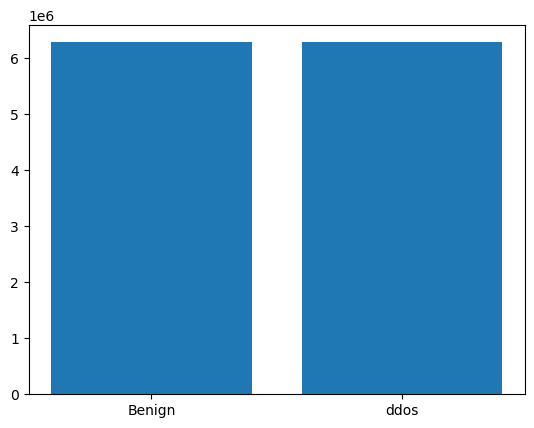

In [35]:
%store -r classes_distr_postcut2
plt.bar(classes_distr_postcut2.keys(), classes_distr_postcut2.values())
plt.show()

In [36]:
sizes = str(os.path.getsize('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut.csv')/(2.0**30)) + " GB"
print('Resulting balanced dataset:', sizes)

Resulting balanced dataset: 5.124122348614037 GB


___
## Subset of BCT

In [8]:
import random

def fair_cut_bis(cut_to, one_class_csvs, classes_distr):

    only_header = pd.read_csv(one_class_csvs[0], nrows=0)
    only_header.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv', mode='w', index=False, header=True)

    for path in one_class_csvs:
        class_name = os.path.dirname(path).split('\\')[-1]

        rows_to_keep = random.sample(range(classes_distr[class_name]), cut_to)
        rows_to_keep.sort()
    
        with pd.read_csv(path, chunksize=mem_limit) as reader:
            for c in reader:
                    to_save = c.copy()
                    to_save = to_save[to_save.index.isin(rows_to_keep)]

                    to_save.to_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv', mode='a', index=False, header=False)

In [9]:
fair_cut_bis(2_000_000, serch_csvs_in_folder(['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes']), classes_distr_precut2)

In [10]:
sizes = str(os.path.getsize('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv')/(2.0**30)) + " GB"
print('Resulting balanced dataset:', sizes)

Resulting balanced dataset: 1.6334192147478461 GB


In [11]:
whole_df=pd.read_csv('.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv')